# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [1]:
import os
os.getcwd()
os.chdir('/root/data/pudae/git/cs231n/pudae/assignment1')

In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


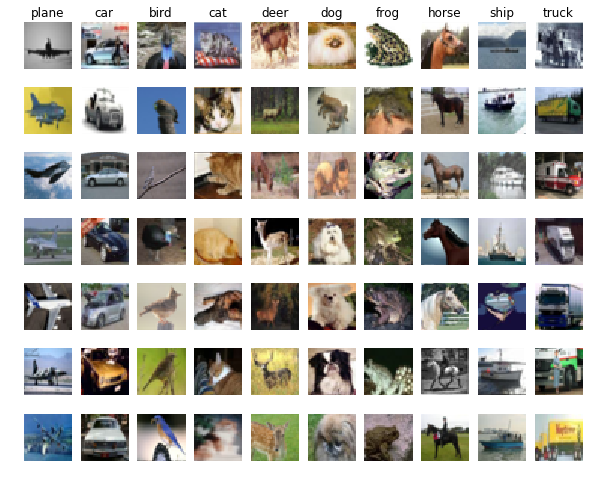

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print X_train.shape, X_test.shape

(5000, 3072) (500, 3072)


In [7]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [8]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print dists.shape

(500, 5000)


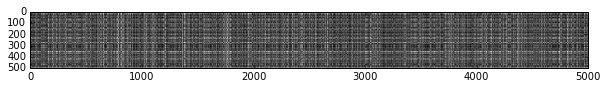

In [9]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

means: [ 115.8219401   114.89615885  110.07161458  107.51269531   96.03222656]
dists: [[ 3254.9938556   3532.2061095   4594.06443142 ...,  3040.65782356
   3134.47523519  4216.15334161]
 [ 3265.08728827  3706.23366775  4235.49878999 ...,  2802.06780789
   2855.5270967   4315.7679502 ]
 [ 3331.07460139  3786.05929695  4428.73808212 ...,  2995.68072398
   3372.35526005  4233.1196534 ]
 [ 2524.74137289  3601.7590147   5075.51810163 ...,  3110.13986824
   3272.80995476  4057.51956249]
 [ 2595.86575154  4070.73334916  5189.28280208 ...,  3308.5582963
   3612.86576003  3208.02665201]]


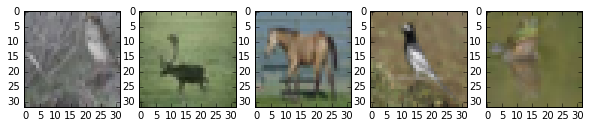

In [10]:
n = 5
indices = np.argsort(np.sum(dists, axis=1))[0:n]
print 'means:', np.mean(X_test[indices], axis=1)
print 'dists:', dists[indices]

for i in xrange(n):
    plt.subplot(1, n, i+1)
    plt.imshow(X_test[indices[i]].reshape((32,32,3)).astype('uint8'))
plt.show()

means: [ 218.59277344  207.52669271  217.16471354  237.73242188  232.82519531]
[[ 7981.59464017  7046.87576164  6826.1990888  ...,  7058.5516928
   5125.97454149  8893.91887753]
 [ 8149.92343522  7187.84578299  7461.71528538 ...,  7237.60740853
   5488.06869491  9019.83869035]
 [ 8358.5234342   7612.03947704  7209.52668349 ...,  7374.99891525
   5607.20019261  9238.4372055 ]
 [ 8221.66406514  7074.9461482   7213.41008123 ...,  7257.58299987
   5428.8088933   9485.8257416 ]
 [ 8370.30136853  7487.37016582  7295.72244538 ...,  7448.85078385
   5472.73249849  9433.67282664]]


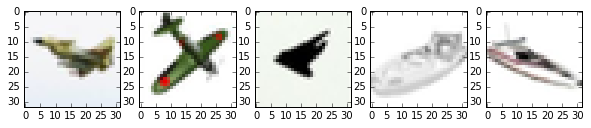

In [11]:
n = 5
indices = np.argsort(np.sum(dists, axis=1))[-n:]
print 'means:', np.mean(X_test[indices], axis=1)
print dists[indices]

for i in xrange(n):
    plt.subplot(1, n, i+1)
    plt.imshow(X_test[indices[i]].reshape((32,32,3)).astype('uint8'))
plt.show()

means: [ 113.16699219  118.51074219  119.7438151   125.40332031  120.67154948]
dists: [[ 2753.57930701  4927.6389884   3871.40039262 ...,  4056.74672613
   1940.96805744  5660.33267574]
 [ 2828.22329387  4900.49487297  3833.78885699 ...,  3644.63111988
   2048.44550818  5276.37129095]
 [ 3069.16584759  4503.96603007  3657.61548006 ...,  3886.93735478
   2270.88991367  5378.9404161 ]
 [ 2988.11830422  4659.95450622  3896.32224027 ...,  3914.17219856
   2030.13768006  5079.15327589]
 [ 3055.90788474  4787.02642566  3745.65628428 ...,  3884.29221352
   2148.37682914  5402.95548751]]


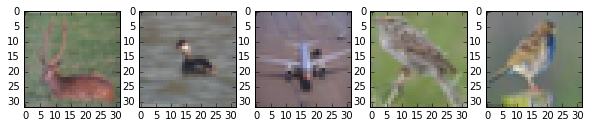

In [12]:
n = 5
indices = np.argsort(np.sum(dists, axis=0))[0:n]
print 'means:', np.mean(X_train[indices], axis=1)
print 'dists:', dists.T[indices]

for i in xrange(n):
    plt.subplot(1, n, i+1)
    plt.imshow(X_train[indices[i]].reshape((32,32,3)).astype('uint8'))
plt.show()

means: [ 223.46516927  216.11230469  228.93489583  198.84049479  236.65169271]
dists: [[ 7473.49443032  6994.70542625  7159.51974646 ...,  5875.89754846
   6458.1608063   3237.00077232]
 [ 7643.36699367  6990.13361818  7285.84593579 ...,  5989.55156919
   6454.97118506  3893.64867444]
 [ 7819.58285332  6798.28985849  7198.14795625 ...,  6289.33136351
   6947.23254253  2865.81489284]
 [ 7514.5009149   7995.71403941  7669.35225427 ...,  5521.07389916
   6414.34486132  4629.04623006]
 [ 7872.83849701  6485.58933328  7187.36919881 ...,  6384.26229098
   7091.26152388  2891.68929866]]


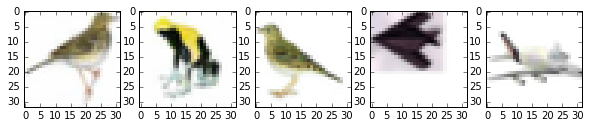

In [13]:
n = 5
indices = np.argsort(np.sum(dists, axis=0))[-n:]
print 'means:', np.mean(X_train[indices], axis=1)
print 'dists:', dists.T[indices]

for i in xrange(n):
    plt.subplot(1, n, i+1)
    plt.imshow(X_train[indices[i]].reshape((32,32,3)).astype('uint8'))
plt.show()

**Your Answer**: *fill this in.*



In [14]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [15]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

In [16]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


In [17]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


In [18]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print 'Two loop version took %f seconds' % two_loop_time

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print 'One loop version took %f seconds' % one_loop_time

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print 'No loop version took %f seconds' % no_loop_time

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 14.282668 seconds
One loop version took 28.644395 seconds
No loop version took 0.200817 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [19]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################


for k in k_choices:
    accuracies = []
    for i in xrange(num_folds):
        X_train_tmp = np.concatenate(tuple(X_train_folds[0:i] + X_train_folds[i+1:]))
        y_train_tmp = np.concatenate(tuple(y_train_folds[0:i] + y_train_folds[i+1:]))
        X_valid_tmp = X_train_folds[i]
        y_valid_tmp = y_train_folds[i]
        
        num_test_tmp = y_valid_tmp.shape[0]
        
        classifier_tmp = KNearestNeighbor()
        classifier_tmp.train(X_train_tmp, y_train_tmp)
        dists_tmp = classifier_tmp.compute_distances_no_loops(X_valid_tmp)
        
        y_valid_pred_tmp = classifier_tmp.predict_labels(dists_tmp, k)
        
        num_correct_tmp = np.sum(y_valid_pred_tmp == y_valid_tmp)
        accuracy = float(num_correct_tmp) / num_test_tmp
        accuracies.append(accuracy)
        
    k_to_accuracies[k] = accuracies

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print 'k = %d, accuracy = %f' % (k, accuracy)

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

[(2, [4, 5, 6]), (4, [1, 2, 3])]


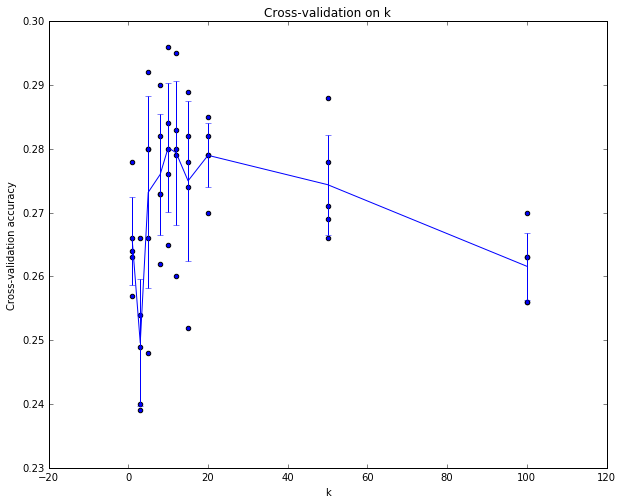

In [20]:
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

tmp_dic = {}
tmp_dic[4] = [1,2,3]
tmp_dic[2] = [4,5,6]
print sorted(tmp_dic.items())

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [21]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = k_choices[np.argmax(accuracies_mean)]

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 141 / 500 correct => accuracy: 0.282000
